# Proyecto Sprint 2
## Ingeniería de features, Modelos avanzados e Interpretación de modelos

### Autor: Nicolás Bianco

Importo las librerías a utilizar

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Librerias agregadas por el proyecto nro 2
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from hpsklearn import HyperoptEstimator
from hpsklearn import any_regressor
from hpsklearn import any_preprocessing
from hyperopt import tpe
from sklearn.ensemble import ExtraTreesRegressor
from scipy import stats

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


Cargo el dataset utilizado

In [2]:
df = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv') # Levanto el dataset en formato .csv utilizando pandas
print("Filas, columas:",df.shape) # Imprimo por pantalla la cantidad de filas y columnas
df.head() # Imprimo por pantalla las 5 primeras instancias

Filas, columas: (146660, 19)


,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


### PARTE A - Transformación de Datos

Para la transformación de los datos voy a comenzar, al igual qu en el proyecto 1, limpiando el dataset de las columnas que no necesito. En principio no voy a utilizar las columnas: 
- lat
- lon
- start_date
- end_date
- created_on
- operation_type

Voy a crear una lista para agregar todas las columnas a eliminar

In [3]:
dropColumns = ['lat','lon','start_date', 'end_date', 'created_on', 'title', 'description', 'operation_type']

Analizo las columnas "l1" y "currency" para ver que tienen dentro

In [4]:
l1 = set(df.l1) # Hago un conjunto para ver los valores distintos que tiene dentro
ccy = set(df.currency)
print(l1,ccy)

{'Argentina'} {'USD'}


Como en "l1" solo tiene "Argentina" y en "currency" solo tiene "USD" entonces tambien los elimino ya que no aportan nada en nuestro objetivo

In [5]:
dropColumns.append('l1')
dropColumns.append('currency')
dropColumns

['lat',
 'lon',
 'start_date',
 'end_date',
 'created_on',
 'title',
 'description',
 'operation_type',
 'l1',
 'currency']

In [6]:
prop = df.drop(columns=dropColumns, axis=1) # elimino las columnas
prop.head()

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
0,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento
1,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH
2,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH
3,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH
4,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,PH


In [7]:
prop.shape

(146660, 9)

In [8]:
prop.describe() # Hago un describe para entender un poco mas los datos

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,146660.000000,146660.000000,140703.000000,126133.000000,125046.000000,1.466600e+05
mean,3.079817,1.983240,1.599994,216.872888,112.818011,2.412211e+05
std,1.416352,1.151304,0.889324,2037.606649,916.857584,3.185195e+05
min,1.000000,0.000000,1.000000,10.000000,1.000000,5.500000e+03
25%,2.000000,1.000000,1.000000,52.000000,47.000000,1.110000e+05
50%,3.000000,2.000000,1.000000,78.000000,68.000000,1.660000e+05
75%,4.000000,3.000000,2.000000,140.000000,108.000000,2.650000e+05
max,35.000000,15.000000,14.000000,193549.000000,126062.000000,3.243423e+07


#### Imputación de valores faltantes

Para el análisis de valores faltantes primero voy a ver cuántos valores faltantes hay por cada columna

In [9]:
print('\nValores faltantes por columna:')
prop.isna().sum(0) # Cuento por cada columna del dataset los valores faltantes


Valores faltantes por columna:


l2                     0
l3                     0
rooms                  0
bedrooms               0
bathrooms           5957
surface_total      20527
surface_covered    21614
price                  0
property_type          0
dtype: int64

Como se puede observar, las columnas con valores faltantes son "bathrooms", "surface_total", "surface_covered". Por esta razón voy a proceder con un análisis de estas columnas para conocer un poco más en detalle cómo se distribuyen los respectivos valores faltantes

##### Valores faltantes en columna `bathrooms`

In [10]:
prop['bathrooms'].describe()

count    140703.000000
mean          1.599994
std           0.889324
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          14.000000
Name: bathrooms, dtype: float64

In [11]:
# Voy a analizar de las 5957 propiedades sin baño qué tipos son
prop['bathrooms'].isna().groupby(prop['property_type']).sum()

property_type
Casa               1337
Casa de campo        21
Cochera             250
Departamento       2696
Depósito            229
Local comercial     171
Lote                835
Oficina             112
Otro                128
PH                  178
Name: bathrooms, dtype: int64

Como se puede observar, la mayoria de las propiedades que no tienen un valor en baños son de tipo "Casa" y "Departamento" lo cual no tiene sentido.
Por esta razon lo que voy a hacer es ponerles el promedio correspondiente a su tipo

In [12]:
prom_banios = prop['bathrooms'].groupby(prop['property_type']).mean().round(0) # Obtengo el promedio de baños por tipo de propiedad
prom_banios

property_type
Casa               2.0
Casa de campo      2.0
Cochera            1.0
Departamento       2.0
Depósito           2.0
Local comercial    2.0
Lote               2.0
Oficina            2.0
Otro               2.0
PH                 1.0
Name: bathrooms, dtype: float64

In [13]:
# Hago una función lambda para que me llene en cada valor faltante el promedio de acuerdo al tipo de propiedad que es
# El promedio lo obtiene del groupby que realizo previamente
prop['bathrooms'] = prop['bathrooms'].groupby(prop['property_type']).apply(lambda x: x.fillna(np.mean(x).round(0)))

prop['bathrooms'].isna().sum() # Cuento la cantidad de valores faltantes que hay en la columna de bathrooms

0

##### Valores faltantes en columna `surface_covered`

In [14]:
# Voy a analizar de las 21614 propiedades sin superficie cubierta qué tipos son
prop['surface_covered'].isna().groupby(prop['property_type']).sum()

property_type
Casa                4865
Casa de campo         64
Cochera              257
Departamento       13889
Depósito             258
Local comercial      303
Lote                1279
Oficina              281
Otro                 263
PH                   155
Name: surface_covered, dtype: int64

Al igual que como sucede con los baños, en la superficie cubierta también los valores faltantes más grandes se encuentran en "Casa" y "Departamento", por lo que también les agregaré el promedio correspondiente a su tipo

In [15]:
prom_supCub = prop['surface_covered'].groupby(prop['property_type']).mean().round(0) # Obtengo el promedio de la superficie cubierta por tipo de propiedad
prom_supCub

property_type
Casa               249.0
Casa de campo      315.0
Cochera             14.0
Departamento        85.0
Depósito           347.0
Local comercial    157.0
Lote               215.0
Oficina             79.0
Otro               203.0
PH                 130.0
Name: surface_covered, dtype: float64

In [16]:
# Hago una función lambda para que me llene en cada valor faltante el promedio de acuerdo al tipo de propiedad que es
# El promedio lo obtiene del groupby que realizo previamente
prop['surface_covered'] = prop['surface_covered'].groupby(prop['property_type']).apply(lambda x: x.fillna(np.mean(x).round(0)))

prop['surface_covered'].isna().sum() # Cuento la cantidad de valores faltantes que hay en la columna de surface_covered

0

##### Valores faltantes en columna `surface_total`

In [17]:
# Analizo de las 20527 propiedades sin superficie total qué tipos son
prop['surface_total'].isna().groupby(prop['property_type']).sum()

property_type
Casa                4917
Casa de campo         64
Cochera              257
Departamento       13577
Depósito             257
Local comercial      301
Lote                 607
Oficina              264
Otro                 154
PH                   129
Name: surface_total, dtype: int64

Como la mayoría tambien se encuentra en propiedades de tipo "Casa" y "Departamento", voy a agregarle el promedio correspondiente a cada tipo

In [18]:
prom_supCub = prop['surface_total'].groupby(prop['property_type']).mean().round(0) # Obtengo el promedio de la superficie cubierta por tipo de propiedad
prom_supCub

property_type
Casa                660.0
Casa de campo      4019.0
Cochera              14.0
Departamento         99.0
Depósito            624.0
Local comercial     259.0
Lote               2481.0
Oficina              82.0
Otro               8250.0
PH                  173.0
Name: surface_total, dtype: float64

In [19]:
# Hago una función lambda para que me llene en cada valor faltante el promedio de acuerdo al tipo de propiedad que es
# El promedio lo obtiene del groupby que realizo previamente
prop['surface_total'] = prop['surface_total'].groupby(prop['property_type']).apply(lambda x: x.fillna(np.mean(x).round(0)))

prop['surface_total'].isna().sum() # Cuento la cantidad de valores faltantes que hay en la columna de surface_covered

0

Controlo que todas en todas las columnas no tengan valores faltantes

In [20]:
print('\nValores faltantes por columna:')
prop.isna().sum(0) # Cuento por cada columna del dataset los valores faltantes


Valores faltantes por columna:


l2                 0
l3                 0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
property_type      0
dtype: int64

#### Detección y eliminación de outliers
Comienzo con el proceso de detección y eliminación de outliers

##### Analisis de la columna `surface_total`

<AxesSubplot:xlabel='surface_total'>

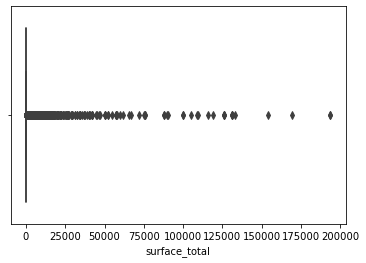

In [21]:
sns.boxplot(data=prop, x='surface_total')

Se puede apreciar que hay una gran disperción de los datos. Al ver el "describe" realizado antes vemos que el 75% de los valores se encuentra por debajo de 140m2.

Pruebo dejando menores a 200m2 para ver su distribución

<AxesSubplot:xlabel='surface_total', ylabel='property_type'>

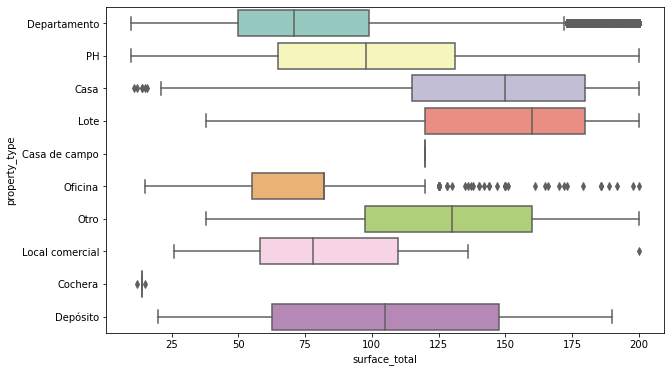

In [22]:
plt.figure(figsize=(10,6))
sns.boxplot(data=prop[(prop.surface_total <= 200)], x='surface_total', y=prop.property_type, palette="Set3")
# En el boxplot no solo filtro para ver las superficies menores a 200m2 sino tambien distingo en el eje "y" 
# los diferentes tipos de propiedades para asegurarmente que todas esten con valores adecuados y se las pueda analizar

La elección de quedarme con aquellas propiedades que tengan una superficie total menor o igual que 200 parece adecuado ya que se puede ver que todos los tipos de propiedades tienen una mejor distribución que antes y tambien cuentan con valores outliers cercanos a cada "caja" del boxplot, para los cuales es buena practica dejar algunos.
Por esta razón voy a realizar este filtro y guardarlo para depurar el dataset

In [23]:
prop = prop[(prop.surface_total <= 200)]
prop.shape

(120537, 9)

<AxesSubplot:xlabel='property_type', ylabel='count'>

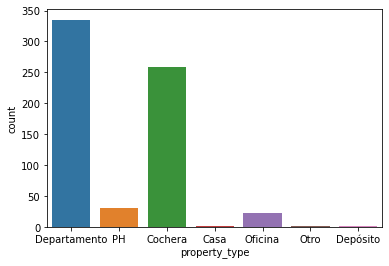

In [24]:
# Además me fijo que tipos de propiedades tienen una superficie total menor que 20
sns.countplot(data=prop[(prop.surface_covered <= 20)],x='property_type')

Se asume que aquellas propiedades de tipo "Departamento", "PH" o "Casa" que tienen una superficie menor a 20 no tienen sentido, por los que las cuento para ver cuantas son para despues eliminarlas.

In [25]:
prop[(prop.surface_covered <= 20) & ((prop.property_type == 'Departamento') | (prop.property_type == 'Casa') | 
            (prop.property_type == 'PH'))]

,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
360,Capital Federal,Caballito,1.0,1.0,2.0,14.0,14.0,27000.0,Departamento
589,Bs.As. G.B.A. Zona Oeste,Tres de Febrero,1.0,1.0,1.0,20.0,20.0,36000.0,PH
593,Capital Federal,Abasto,1.0,1.0,1.0,20.0,20.0,59000.0,Departamento
1205,Capital Federal,Almagro,1.0,1.0,1.0,28.0,18.0,61000.0,Departamento
1321,Capital Federal,Belgrano,1.0,1.0,1.0,33.0,3.0,115000.0,Departamento
...,...,...,...,...,...,...,...,...,...
145640,Bs.As. G.B.A. Zona Sur,Lanús,3.0,2.0,1.0,99.0,1.0,95000.0,Departamento
145641,Bs.As. G.B.A. Zona Sur,Lanús,1.0,1.0,1.0,65.0,20.0,38000.0,PH
146015,Capital Federal,Palermo,1.0,1.0,1.0,20.0,20.0,85000.0,Departamento
146209,Bs.As. G.B.A. Zona Norte,Vicente López,2.0,1.0,1.0,173.0,1.0,99000.0,PH


In [26]:
# Se procede a eliminar esas 367 instancias que se consideran erroneas
prop = prop.drop(prop[(prop.surface_covered <= 20) & ((prop.property_type == 'Departamento') | (prop.property_type == 'Casa') | 
            (prop.property_type == 'PH'))].index)
prop.shape

(120170, 9)

##### Analisis de la columna `price`

<AxesSubplot:xlabel='price'>

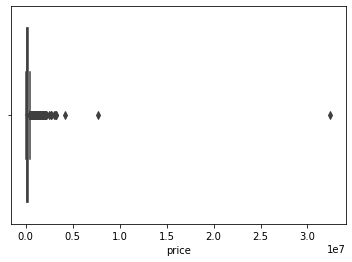

In [27]:
sns.boxplot(data=prop, x='price')

Al igual que sucedió con el análisis inicial de la superficie total, en el precio también hay mucha dispersión en la información con outliers muy alejados que solo generan ruido.
Voy a comenzar analizando las propiedades con valor menor a 400.000 USD al igual que en el proyecto 1

<AxesSubplot:xlabel='price', ylabel='property_type'>

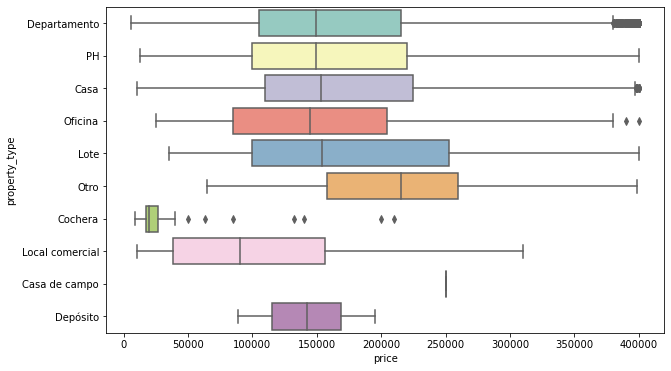

In [28]:
plt.figure(figsize=(10,6))
sns.boxplot(data=prop[(prop.price <= 400000)], x='price' , y= prop.property_type, palette="Set3")

Al quedarme con las propiedades de precio menor a 400.000 USD se logra ver mejor el boxplot. Los rangos que se ven en el grafico tienen sentido por lo que se da por finalizado el análisis de precios.

In [29]:
# Elimino aquellas instancias que tienen precios por encima de 400.000USD
prop = prop[(prop.price <= 400000)]
prop.shape

(112271, 9)

#### Encoding

El tercer paso que voy a realizar para la Parte A es la tecnica de "encoding". Por lo visto en clase y lo que busqué en internet las tecnicas mas usadas son "Label Encondig" y "One Hot Encoding".
La que yo voy a usar es "One Hot Encoding" ya que si utilizo la de "label" el modelo al aprender podria mal interpretar los barrios ya que les asignaria a cada uno un codigo entre 0 y N. Esto podria hacer que tome como barrios más importantes los que tienen un codigo más alto, lo cual no es correcto.

Las columnas a tratar son "l2", "l3" y "property_type"

Para hacerlo de manera más rapida, voy a crear una función que me devuelva el dataframe con las columnas agregadas

In [30]:
def oneHotEncoder(df, feature):
    '''
    Dados el dataframe y la columna para procesar con la tecnica One-Hot Encoding
    devuelve el dataframe con las columnas agregadas y elimina la columna que se procesó
    
    Arguments:
    df -- DataFrame a tratar
    feature -- Nombre de la columna que se quiere procesar por one hot encoding
   
    Returns:
    res -- dataframe con la columna a procesar eliminada y agragando la cantindad de columnas necesarias de acuerdo al onehot
        
    '''

    dummies = pd.get_dummies(df[[feature]]) # Obtengo un nuevo dataframe en donde cada columna es un valor distinto dentro del "feature"
    res = pd.concat([df, dummies], axis=1) # Concateno el dataframe original con el nuevo
    res = res.drop([feature], axis=1) # Elimino del dataframe resultante la columna que quiero tratar por one hot
    
    return(res)

In [31]:
# Lo que voy a realizar es ir pasando por la función que acabo de crear las 3 features categoricas 
# que quiero pasar por one hot para que me devuleva el dataframe terimnado

df_OH_propTypes = oneHotEncoder(prop,'property_type') # hago el one-hot para "property_type"

df_OH_l2 = oneHotEncoder(df_OH_propTypes,'l2') # hago el one-hot para "l2"

df_OH = oneHotEncoder(df_OH_l2,'l3') # Para finalizar, hago el one-hot para "l3"

df_OH.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Casa de campo,property_type_Cochera,property_type_Departamento,...,l3_Villa Lugano,l3_Villa Luro,l3_Villa Ortuzar,l3_Villa Pueyrredón,l3_Villa Real,l3_Villa Riachuelo,l3_Villa Santa Rita,l3_Villa Soldati,l3_Villa Urquiza,l3_Villa del Parque
0,7.0,7.0,2.0,140.0,140.0,153000.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.0,1.0,1.0,50.0,35.0,40000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
df_OH.shape

(112271, 109)

Ahora mi dataframe tiene 109 columnas

#### Analisis de correlación entre variables

<function matplotlib.pyplot.show(close=None, block=None)>

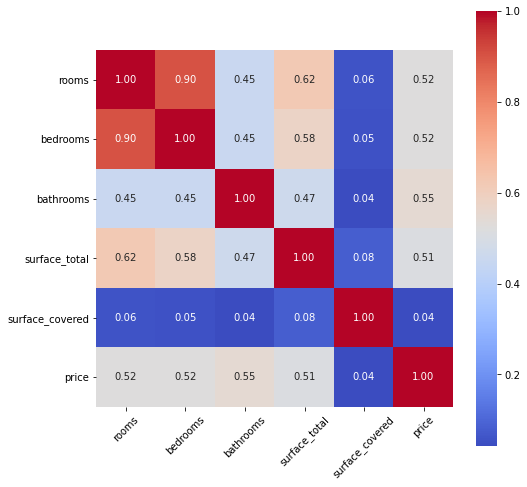

In [33]:
# Realizo un heatmap para visualizar en un mapa de calor las correlaciones mas fuertes
plt.figure(figsize=(8,8))
sns.heatmap(df_OH[['rooms','bedrooms','bathrooms','surface_total','surface_covered','price']].corr(),cmap= 'coolwarm',cbar = True, square = True, annot=True, fmt= '.2f')
plt.xticks(rotation = 45)
plt.show

#seaborn.heatmap(df[[col1, col2]], ...)

Analizando el mapa de calor, podemos decir que no hay grandes correlaciones entre las variables. Incluso las variables "rooms" y "bedrooms" son similares, tienen una correlación fuerte entre ellas y se comportan de manera similar con el resto de las variables, por lo que podriamos prescindir de alguna de las dos.

#### Comparación con el modelo implementado en la Entrega 01 - Arbol de Decisión

En el primer proyecto para el árbol de decisión escogí como mejores hiperparámetros max_depth=6
La métrica para evaluar la performance había usado RMSE.
Evaluando mi modelo de árbol de decisión con RMSE en train y test obtuve los siguientes resultados:

- Raíz del error cuadrático medio en Train: 159067.539460302
- Raíz del error cuadrático medio en Test: 166034.1200011022

Ahora voy a realizar un train test split de los datos con mi nuevo dataframe y evaluarlo con RMSE para validar si mejora o no

In [34]:
df_OH.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Casa de campo,property_type_Cochera,property_type_Departamento,...,l3_Villa Lugano,l3_Villa Luro,l3_Villa Ortuzar,l3_Villa Pueyrredón,l3_Villa Real,l3_Villa Riachuelo,l3_Villa Santa Rita,l3_Villa Soldati,l3_Villa Urquiza,l3_Villa del Parque
0,7.0,7.0,2.0,140.0,140.0,153000.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.0,1.0,1.0,50.0,35.0,40000.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# Realizo el train/test split
from sklearn.model_selection import train_test_split

X_pa = df_OH.drop(['price'],axis=1) # Obtengo mis features
y_pa = df_OH.price # Target
X_train_pa, X_test_pa, y_train_pa, y_test_pa = train_test_split(X_pa, y_pa,test_size=0.3, random_state=42)

In [36]:
reg_tree = DecisionTreeRegressor(max_depth=6) # Creo el modelo arbol de regresión con el hiperparámetro seleccionado

reg_tree.fit(X_train_pa, y_train_pa) # Entreno los modelos

DecisionTreeRegressor(max_depth=6)

In [37]:
# Realizo la predicción con mi modelo recién creado y entrenado

y_train_pred_pa = reg_tree.predict(X_train_pa)
y_test_pred_pa = reg_tree.predict(X_test_pa)

rmse_train = np.sqrt(mean_squared_error(y_train_pa, y_train_pred_pa)).round(2) # Calulo la RMSE en train
rmse_test = np.sqrt(mean_squared_error(y_test_pa, y_test_pred_pa)).round(2) # Caluculo la RMSE en test
print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

Raíz del error cuadrático medio en Train: 50600.52
Raíz del error cuadrático medio en Test: 50473.01


#### Conclusiones
Luego de realizar la transformación de los datos se puede concluir que el error mejoró notablemente.
Se redujo el error en casi la mitad en train aunque no tanto en test.
Esto se debe no solo a que se hizo un tratamiento de los outliers y valores faltantes sino que ahora el modelo tiene muchas mas features de las cuales aprender. El hecho de realizar una técnica de encoding le permite al modelo que pueda aprender de muchas mas columnas 

### PARTE B - Modelos Avanzados

Para simplificar las evaluaciones de los modelos primero voy a crear una función que evalúe y grafique los modelos que voy a ir creando

In [38]:
def evaluar_regresion(model,x,y, X_train, X_test, y_train, y_test):
    '''
    Dados el modelo previamente entrenado y el train/test split de los datos
    predice el modelo, imprime el error RMSE y grafica dichos errores
    
    Arguments:
    model -- Modelo entrenado
    x -- Features
    y -- Variable target
    X_train -- Features de train
    X_test -- Features de test
    y_train -- Target para train
    y_test -- target para test
           
    '''

    y_train_pred = model.predict(X_train) #Predigo con train
    y_test_pred = model.predict(X_test) # Predigo con test
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred)) # Caluclo el error en train
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred)) # Caluculo el error en test

    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

    
    ### GRAFICO LOS RESULTADOS
    plt.figure(figsize=(16,8))
    
    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)

    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # minimo de los ejes x e y
    np.max([ax.get_xlim(), ax.get_ylim()]),  # maximo de los ejes x e y
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show()

Realizo el train/test split de los datos a partir del dataset transformado en la parte A

In [39]:
X = df_OH.drop(['price'],axis=1) # Obtengo mis features
y = df_OH.price # Target

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)

#### Elección de modelos avanzados
Para la elección de dos modelos avanzados vistos en clase voy a optar por desarrollar Random Forest y AdaBoost.
Luego de desarrollar cada uno voy a agregar las técnicas de Cross Validation y Random Serch para ver si dichos modelos mejoran

##### Random Forest

In [40]:
# Creo el modelo usando random forest
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train,y_train) # Entreno el modelo

y_test_pred_RF = rf_reg.predict(X_test)

Raíz del error cuadrático medio en Train: 20061.64049743907
Raíz del error cuadrático medio en Test: 32754.16814331505


C:\Users\nicob\anaconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\nicob\anaconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


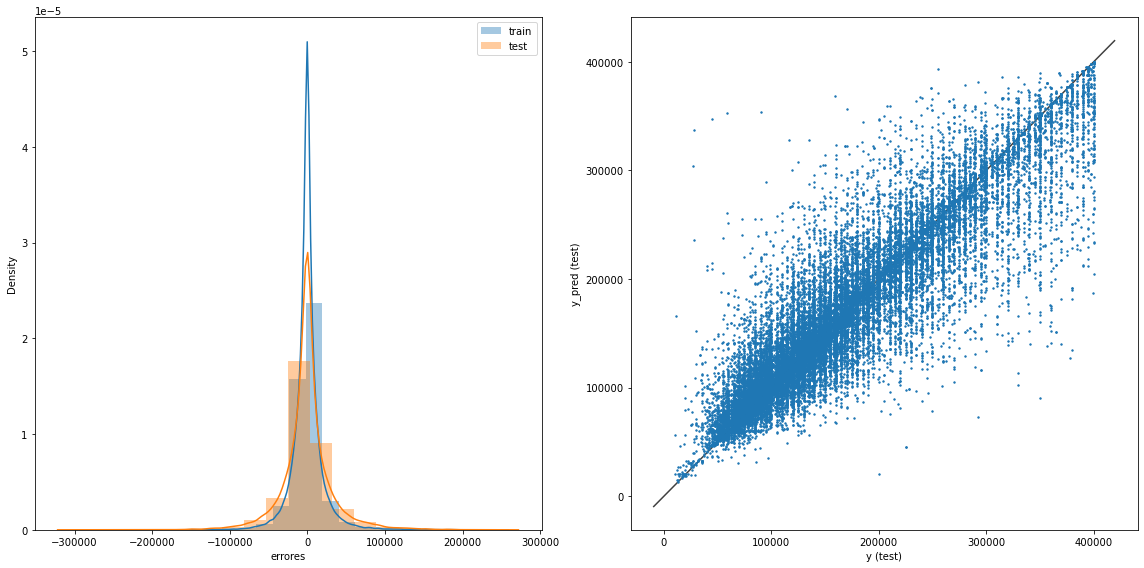

In [41]:
# Ya habiendo entrenado el modelo y predicho el valor de "y" voy a ver cómo dieron los resultados
evaluar_regresion(rf_reg,X,y,X_train, X_test, y_train, y_test)

Aplicando random forest se logró reducir el error tanto en train y test notablemente. Este algoritmo, a diferencia de knn y árbol de decisión es mucho más robusto para poder encontrar una solución acorde al problema planteado. 

Ahora para seguir mejorando esto, voy a usar validación cruzada y random search

##### Random Forest con Cross Validation y Random Serch

Primero voy a chequear los parametros por default que está usando el modelo recién creado

In [42]:
print('Parámetros en uso')
rf_reg.get_params()

Parámetros en uso


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Habiendo visto los parámetros usados por el modelo con random forest, ahora voy a usar Random Serch con Cross Validation para encontrar los parámetros ótimos.
La elección de RandomSerch por sobre GridSerch es que no quiero que busque de manera exhaustiva los mejores parámetros combinando todas las opciones posibles, sino hacerlo de manera random para que finalice más rapido

In [43]:
# Voy a indicar los parámetros para la grilla del Random Serch

# Numero de árboles en random forest
n_estimators = np.linspace(start = 100, stop = 1000, num = 5, dtype=int)
# Numero de features para considerar por split
max_features = ['auto', 'sqrt']
# Profundidad máxima del árbol
max_depth = [10,50,100]
max_depth.append(None)
# Cantidad minima de muestras requeridas al separar un nodo
min_samples_split = [2, 5, 10]
# Cantidad mínima de muestras requeridas en un nodo hoja
min_samples_leaf = [1, 2, 4]

# Creo la random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': array([ 100,  325,  550,  775, 1000]), 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 50, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


Ahora sí, ya teniendo la grilla para hacer el random serch con el cross validation voy a proceder a crearlo

##### NOTA: Las siguientes lineas las dejo comentadas ya que no logran llegar a una solución en un tiempo acotado. Luego de dejar corriendo durante 3 horas no terminó de encontrar una solución por lo que tuve que interrumpir su corrida.

In [44]:
rf_reg_RS = RandomizedSearchCV(estimator=rf_reg, param_distributions=random_grid, n_iter=25, cv=3, verbose=2, random_state=42, n_jobs=-1)

In [45]:
# Entreno el modelo
#rf_reg_RS.fit(X_train,y_train)

In [46]:
# Predigo el modelo con datos de test
#y_test_pred_RS = rf_reg_RS.predict(X_test)

In [47]:
# Calcular el error con RMSE sobre este modelo y graficar los resultados
#evaluar_regresion(rf_reg_RS,X,y,X_train, X_test, y_train, y_test)

##### ADABoost

In [48]:
# Creo el modelo usando ADABoost
ada_reg = AdaBoostRegressor(random_state=42)
#Entreno el modelo
ada_reg.fit(X_train,y_train)

AdaBoostRegressor(random_state=42)

In [49]:
# Predigo 'y' con los datos de test
y_test_pred_AB = ada_reg.predict(X_test)

Raíz del error cuadrático medio en Train: 63331.61855526091
Raíz del error cuadrático medio en Test: 62980.698323322846


C:\Users\nicob\anaconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\nicob\anaconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


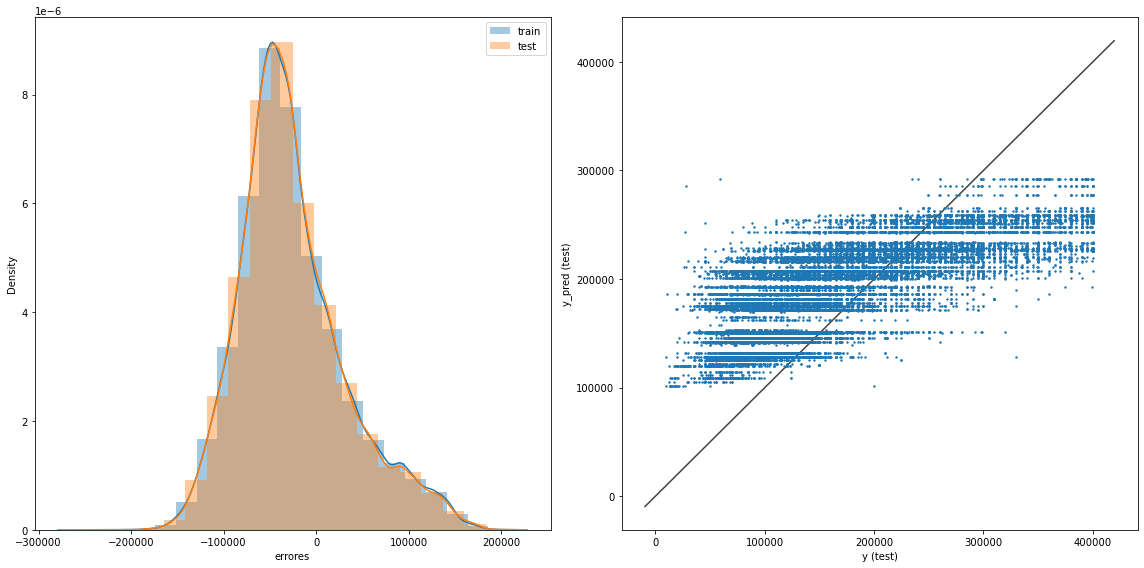

In [50]:
# Calcular el error con RMSE sobre este modelo y graficar los resultados
evaluar_regresion(ada_reg,X,y,X_train, X_test, y_train, y_test)

A modo de conclusión sobre el modelo realizado con AdaBoost se puede apreciar también una mejora respecto al modelo entrenado en la parte A, sin embargo el error es mayor que el modelo realizado con Random Forest. 
De todas maneras, para mejorar este modelo lo que voy a hacer es optimizar los hiperparámetros utilizando, al igual que en el caso anterior, Random Serch y CV

##### ADABoost con Cross Validation y Random Serch

Chequeo los parametros por default que está usando el modelo recién creado

In [51]:
print('Parámetros en uso')
ada_reg.get_params()

Parámetros en uso


{'base_estimator': None,
 'learning_rate': 1.0,
 'loss': 'linear',
 'n_estimators': 50,
 'random_state': 42}

In [52]:
# Voy a indicar los parámetros para la grilla del Random Serch

# Numero de árboles en random forest
n_estimators = np.linspace(start = 50, stop = 200, num = 4, dtype=int)
# Learning Rate del modelo
learning_rate = [0.01,0.05,0.1,0.3,1]
# Función de pérdida
loss = ['linear', 'square', 'exponential']

# Creo la random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'loss': loss}

print(random_grid)

{'n_estimators': array([ 50, 100, 150, 200]), 'learning_rate': [0.01, 0.05, 0.1, 0.3, 1], 'loss': ['linear', 'square', 'exponential']}


In [53]:
# Ahora creo el modelo usando la grilla para encontrar los mejores hiperparámetros
ada_reg_RS = RandomizedSearchCV(ada_reg, param_distributions = random_grid, cv=3, n_iter = 10, n_jobs=-1)

In [54]:
# Entreno el modelo
ada_reg_RS.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=AdaBoostRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.3,
                                                          1],
                                        'loss': ['linear', 'square',
                                                 'exponential'],
                                        'n_estimators': array([ 50, 100, 150, 200])})

In [55]:
# Imprimo los mejores parámetros y los mejores scores
print("Mejores parametros: "+str(ada_reg_RS.best_params_))
print("Mejor Score: "+str(ada_reg_RS.best_score_))

Mejores parametros: {'n_estimators': 50, 'loss': 'linear', 'learning_rate': 0.1}
Mejor Score: 0.5196129921845505


In [56]:
# Hago el 'predict' con este modelo usando el set de entrenamiento
y_test_pred_AB_RS = ada_reg_RS.predict(X_test)

Raíz del error cuadrático medio en Train: 56649.42439659926
Raíz del error cuadrático medio en Test: 56202.32231882336


C:\Users\nicob\anaconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\nicob\anaconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


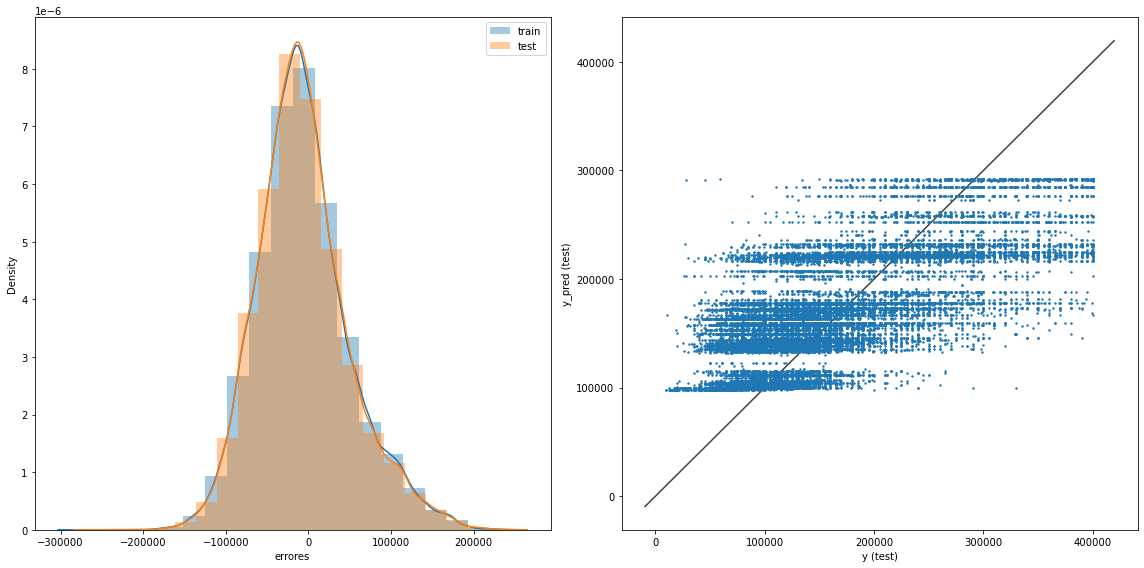

In [57]:
# Calcular el error con RMSE sobre este modelo y graficar los resultados
evaluar_regresion(ada_reg_RS,X,y,X_train, X_test, y_train, y_test)

Realizando el random serch con cross validation en el modelo de AdaBoost se logró reducir el error pero no de una manera significativa. 
Comparandolo con el modelo creado en la parte A obtengo un mejor resultado. Sin embargo no considero que este modelo sea lo suficientemente eficiente para resolver nuestro problema

#### Comparación entre Random Forest y ADABoost
Luego de realizar el ejercicio con modelos utilizando RandomForest y ADABoost se puede concluir en que hay un claro mejor rendimiento utilizando Random Forest. Incluso, mejorando los hiperparámentros con RandomSerch y CV en ADABoost no se logra un resultado adecuado.
Por esta razón entiendo que RandomForest es un modelo mucho mas robusto que provee una mejor solución a nuestro problema. Si pudiera terminar de correr el RandomSerch con CV en dicho modelo, seguramente tendriamos un modelo mucho mejor.

#### Optimización de hiperparámetros
Dado que no logré obtener los mejores hiperparámetros con Random Serch y CV para el modelo con Random Forest, voy a utilizar la librería de HyperOtp. Esta librería ayuda justamente a encontrar los mejores hiperparámetros de una manera más eficiente que RandomizedSerchCV. La gran ventaja de este modelo es que podemos indicarle un tiempo de "time out" de manera que devuelva lo mejor que encontró en ese tiempo dado

In [62]:
# Le indico al modelo que quiero que evalue los datos entre sus modelos de regresión y lo optimice.
# Además puedo seleccionar la métrica para medir el error del modelo devuelto, por lo que selecciono "MSE" para luego calcular el RMSE
# En cuanto al tiempo de timeout le indico que quiero 180 segundos, o sea 3 minutos para que evalue cada ciclo

hyperoOpt = HyperoptEstimator(regressor=any_regressor('reg'), preprocessing=any_preprocessing('pre'),
                             loss_fn=mean_squared_error, algo=tpe.suggest, max_evals=50, trial_timeout=180, verbose=True)


In [63]:
#Entreno el modelo con mis datos de train y test
hyperoOpt.fit(X_train, y_train)

100%|██████████| 2/2 [01:14<00:00, 74.08s/trial, best loss: 1488577270.2724345]
TERMINATING DUE TO TIMEOUT                           
100%|██████████| 6/6 [00:21<00:00, 21.45s/trial, best loss: 1488577270.2724345]
TERMINATING DUE TO TIMEOUT                           
100%|██████████| 7/7 [03:04<00:00, 184.07s/trial, best loss: 1488577270.2724345]
TERMINATING DUE TO TIMEOUT                           
100%|██████████| 13/13 [00:37<00:00, 37.75s/trial, best loss: 1079698032.4752383]
TERMINATING DUE TO TIMEOUT                             
100%|██████████| 15/15 [00:23<00:00, 23.72s/trial, best loss: 1079698032.4752383]
TERMINATING DUE TO TIMEOUT                             
100%|██████████| 17/17 [00:31<00:00, 31.26s/trial, best loss: 1079698032.4752383]
TERMINATING DUE TO TIMEOUT                             
100%|██████████| 19/19 [00:36<00:00, 36.37s/trial, best loss: 1079698032.4752383]
TERMINATING DUE TO TIMEOUT                             
100%|██████████| 21/21 [00:30<00:00, 30.31s/t

In [64]:
# Imprimo el mejor medelo encontrado
print(hyperoOpt.best_model())

{'learner': ExtraTreesRegressor(bootstrap=True, max_features='log2', n_estimators=124,
                    n_jobs=1, random_state=0, verbose=False), 'preprocs': (Normalizer(norm='l1'),), 'ex_preprocs': ()}


In [65]:
# Ya teniendo el mejor modelo obtenido predigo "y" con los datos de test
y_pred_test_hyperOpt = hyperoOpt.predict(X_test)

Fitting Normalizer(norm='l1') to X of shape (33682, 108)
Transforming Xfit (33682, 108)


Fitting Normalizer(norm='l1') to X of shape (78589, 108)
Transforming Xfit (78589, 108)
Fitting Normalizer(norm='l1') to X of shape (33682, 108)
Transforming Xfit (33682, 108)
Raíz del error cuadrático medio en Train: 19868.529393277557
Raíz del error cuadrático medio en Test: 31560.793703193925


C:\Users\nicob\anaconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\nicob\anaconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


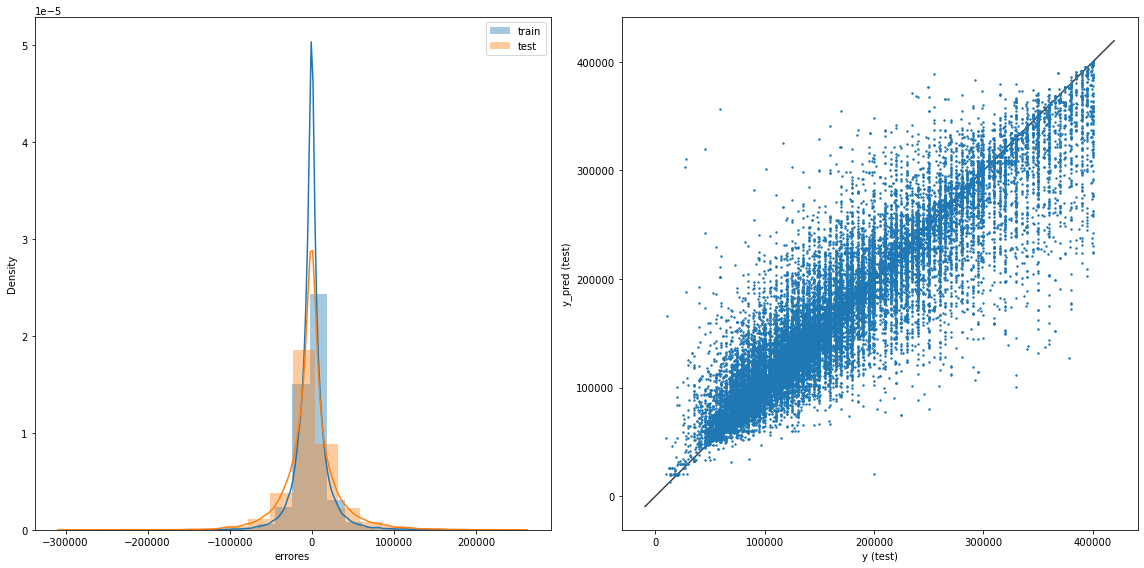

In [66]:
# Evalúo el modelo
evaluar_regresion(hyperoOpt,X,y,X_train, X_test, y_train, y_test)

#### Conclusion: Comparación entre HyperOpt y RandomForest
En el mejor modelo encontrado usando la librería HyperOpt obtengo un modelo con un error un poco más bajo comparandolo con el error obtenido en RandomForest.
Si bien el modelo es un poco mejor, cabe aclarar dos puntos que son importantes:
- No se realizó el modelo de RandomForest con RandomSerch y CV
- El modelo obtenido con HyperOpt fue el mejor modelo encontrado en el tiempo indicado. Si en lugar de darle un timeout de 3 minutos hubiese sido mas tiempo, seguramente nos encontrariamos ahora con un mejor modelo

Para continuar con el análisis de la parte C voy a utilizar el modelo obtenido justamente con HyperOpt

### PARTE C - Interpretación de modelos

In [67]:
# Creo el modelo con los hyperparámetros obtenidos luego de encontrar el "best_model" en HyperOpt

reg = ExtraTreesRegressor(bootstrap=True, max_features='log2', n_estimators=124,
                    n_jobs=1, random_state=0, verbose=False)
# Entreno el modelo
reg.fit(X_train,y_train)

ExtraTreesRegressor(bootstrap=True, max_features='log2', n_estimators=124,
                    n_jobs=1, random_state=0, verbose=False)

In [68]:
y_train_pred = reg.predict(X_train) #Predigo con train
y_test_pred = reg.predict(X_test) # Predigo con test

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred)) # Caluclo el error en train
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred)) # Caluculo el error en test

print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
print(f'Raíz del error cuadrático medio en Test: {rmse_test}')

Raíz del error cuadrático medio en Train: 19884.789699156547
Raíz del error cuadrático medio en Test: 31940.347747596057


#### Relevancia de features

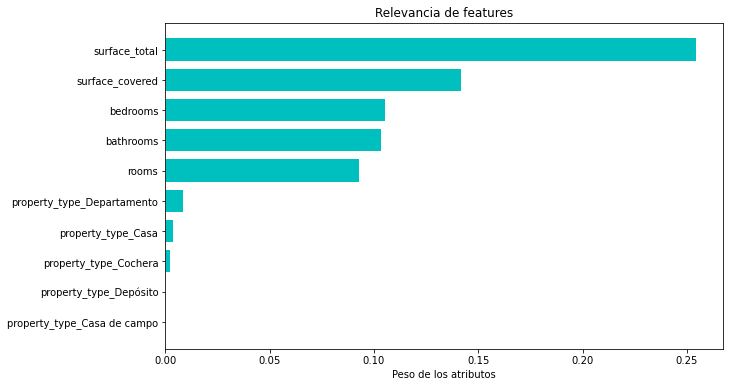

In [69]:
# Con el modelo creando con HyperOpt, el cual es un ExtraTreeRegressor voy a analizar los atributos que tienen más importancia
# Realizo el top 10 de features mas relevantes
mejoresAtributos = reg.feature_importances_[:10]

# Obtengo las features de mi modelo
features = X_test.columns

# Obtengo los indices ordenados de menor a mayor
index = np.argsort(mejoresAtributos)

# Grafico en un grafico de barras
plt.figure(figsize=(10,6))
plt.title('Relevancia de features')
plt.barh(range(len(index)), mejoresAtributos[index], color='c', edgecolor = 'w', linewidth=2)
plt.yticks(range(len(index)), [features[i] for i in index])
plt.xlabel('Peso de los atributos')
plt.show()


Como se puede observar, se le da mucho peso a las variables que vienen en el dataset original, siendo las más importantes las relacionadas a la superficie de la propiedad. Esto era justamente lo que yo esperaba a priori antes de ver la importancia que le da a cada atributo, ya que dichos atributos son los que debieran tener mayor peso frente a los que se crearon por OneHot

Como siguiente paso, voy a elegir al azar algunos modelos tambien de ExtraTreeRegressor para ver como se comporta la importancia que le da cada uno de ellos a los features

In [70]:
reg.estimators_

[ExtraTreeRegressor(max_features='log2', random_state=209652396),
 ExtraTreeRegressor(max_features='log2', random_state=398764591),
 ExtraTreeRegressor(max_features='log2', random_state=924231285),
 ExtraTreeRegressor(max_features='log2', random_state=1478610112),
 ExtraTreeRegressor(max_features='log2', random_state=441365315),
 ExtraTreeRegressor(max_features='log2', random_state=1537364731),
 ExtraTreeRegressor(max_features='log2', random_state=192771779),
 ExtraTreeRegressor(max_features='log2', random_state=1491434855),
 ExtraTreeRegressor(max_features='log2', random_state=1819583497),
 ExtraTreeRegressor(max_features='log2', random_state=530702035),
 ExtraTreeRegressor(max_features='log2', random_state=626610453),
 ExtraTreeRegressor(max_features='log2', random_state=1650906866),
 ExtraTreeRegressor(max_features='log2', random_state=1879422756),
 ExtraTreeRegressor(max_features='log2', random_state=1277901399),
 ExtraTreeRegressor(max_features='log2', random_state=1682652230),
 E

In [73]:
# Selecciono 10 modelos al azar del listado anterior
modelos = np.random.choice(reg.estimators_, size = 10, replace = False)

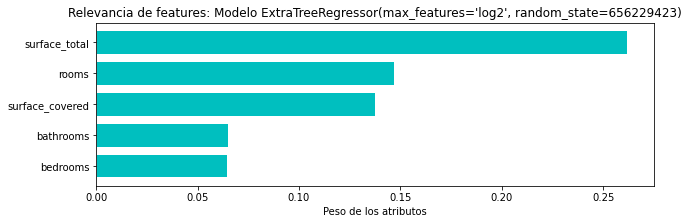

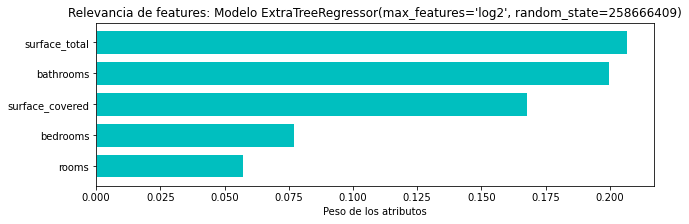

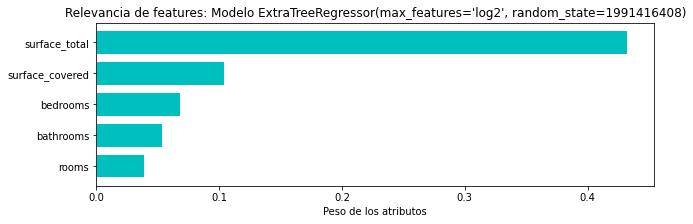

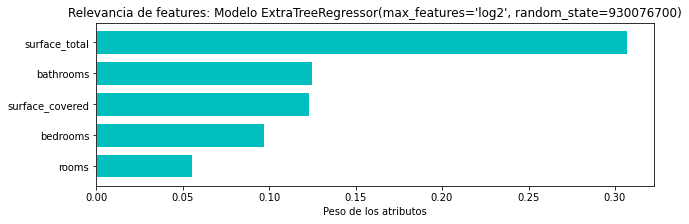

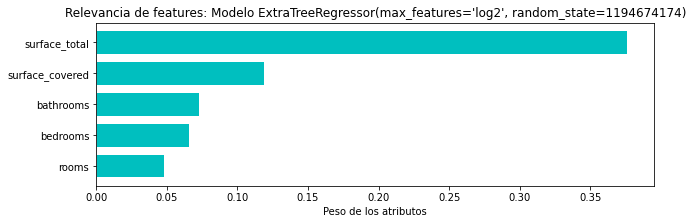

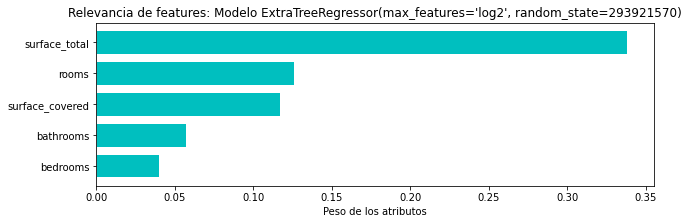

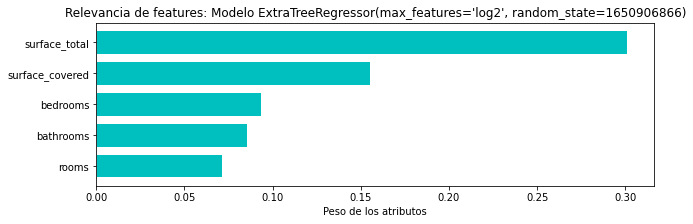

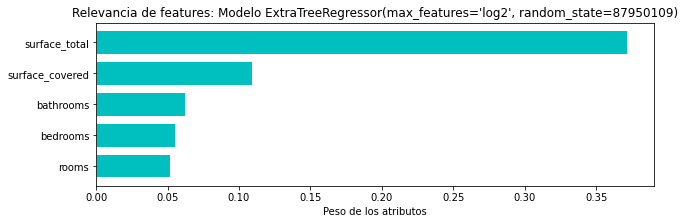

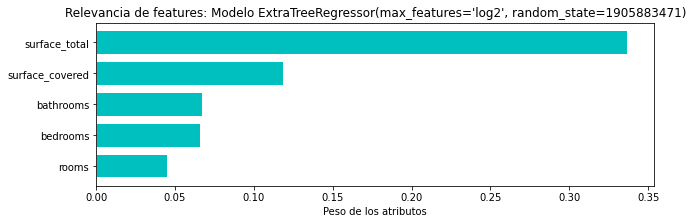

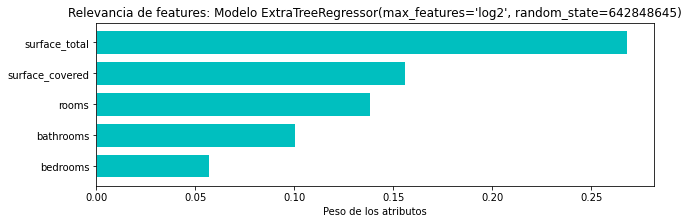

In [74]:
for modelo in modelos: 
    mejoresAtributos = modelo.feature_importances_[:5] # Obtengo las 5 features mas importantes
    features = X_test.columns
    index = np.argsort(mejoresAtributos)
    plt.figure(figsize=(10,3))
    plt.title('Relevancia de features: Modelo '+str(modelo))
    plt.barh(range(len(index)), mejoresAtributos[index], color='c', edgecolor = 'w', linewidth=2)
    plt.yticks(range(len(index)), [features[i] for i in index])
    plt.xlabel('Peso de los atributos')
    plt.show()

Como se esperaba, los 5 features mas importantes de cada modelo continuan siendo los originales del dataset. Se puede observar la diferencia entre cada uno, donde todos los atributos tienen distinto peso en cada modelo y por supuesto tambien cambia sus posiciones en cuanto a la importancia

#### Distribución del error
Para entender un poco más como se distribuye el error voy a calcularlo haciendo simplemente la diferencia entre el `y_test` y el `y_pred_test`

C:\Users\nicob\anaconda3\envs\datascience\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

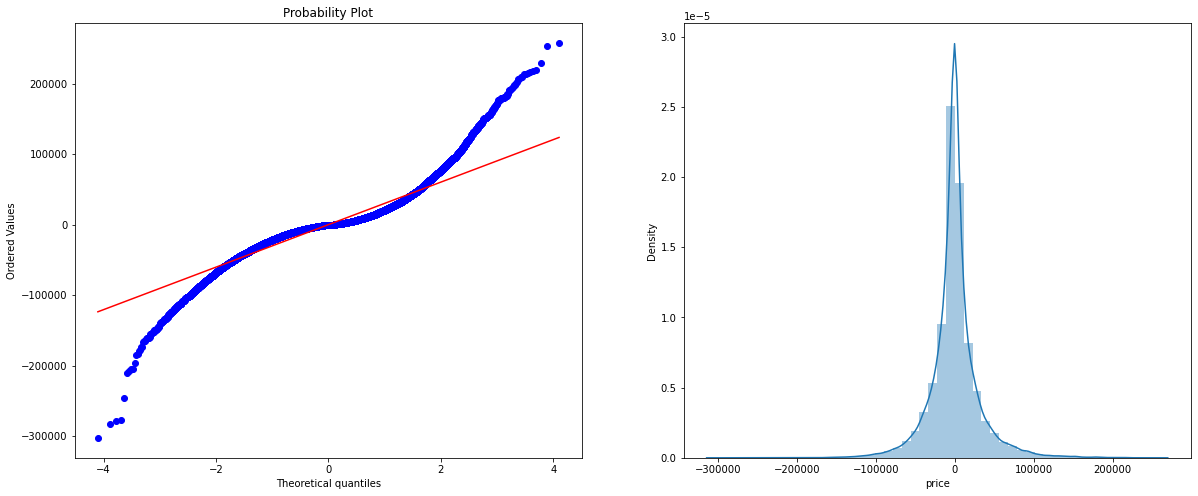

In [75]:
error = y_test - y_test_pred

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
stats.probplot(error, dist="norm", plot=plt)

plt.subplot(1,2,2)
sns.distplot(error)

#### Conclusión: Error
Al observar los gráficos podemos entender mejor cómo es el error en nuestro modelo. 
En primera instancia, al analizar el primer gráfico, donde se muestra cómo se distribuyen los errores respecto al valor teorico, se puede ver que se encuentra bastante cercana a lo esperado y en las puntas el error aumenta, lo que podría deberse a outliers.

En cuanto al segundo gráfico podemos observar el comportamiento normal de la curva de errores en donde la mayor parte se encuentran cercana a 0 y contiene la mayor parte entre más menos 10000, lo cual está en concordancia con el error obtenido en test.

### Conclusiones generales

Las técnicas utilizadas en la parte A relacionadas con la transformación de datos fueron de suma importancia para mejorar la performance de los modelos a realizar. Esto se puede ver simplemente comparando el modelo usando en el Proyecto 1 con ese mismo modelo pero con los datos luego de transformarlos.

Respecto a los modelos avanzados evaluados se puede concluir que el modelo de RandomForest es un modelo muy robusto que tiene una performance muy buena, reduciendo notablemente el error. Si dicho modelo pudiese ser mejorado al utilizar optimización de hiperparámentros seguramente el resulado sería mucho mejor. De todas maneras, al utilizar la librería de HyperOpt pude obtener un modelo adecuado teniendo en cuenta que le indiqué un timeout de solo 180 segundos.

Una cosa que me gustaría resaltar, a modo de conclusión final, es que la optimización de hiperparámentros utilizando RandomizedSerchCV aunque tiene la ventaja de ser sencilla de programar, tiene una gran desventaja relacionada con el tiempo que requiere para terminar su ejecución. Es una lástima que no pude obtener un resultado con el RandomForest ya que considero que pudo haber bajado notablemente el error. Por esta razón es que me resulta muy beneficioso el uso de HyperOpt ya que además de ser muy sencilla de usar se obtienen grandes resultados considerando el tiempo de procesamiento.